In [1]:
import pyspark

sc = pyspark.sql.SparkSession.Builder().getOrCreate()

## Levanto los archivos

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
birds_recep_df = sc.read.json('../datos/all-birds-data.jsonlines/')
birds_recep = birds_recep_df.rdd

In [10]:
#
START_TIME = '08:00:00'
END_TIME = '19:00:00'
start_date = '2018-01-10'
end_date = '2018-01-26'

(
    birds_recep
    .filter(lambda x: x['tag_id'] == 15)
    .filter(lambda x: x['timestamp'] >= start_date and  x['timestamp'] < end_date)
    #.filter(lambda x: START_TIME <= x['timestamp'].split(' ')[1] < END_TIME)
    .count()
),(
    birds_recep
    .filter(lambda x: x['tag_id'] == 16)
    .filter(lambda x: x['timestamp'] >= start_date and  x['timestamp'] < end_date)
    #.filter(lambda x: START_TIME <= x['timestamp'].split(' ')[1] < END_TIME)
    .count()
)

(14958, 25430)

In [28]:
aux = pd.DataFrame(
    birds_recep
    .filter(lambda x: x['tag_id'] == 15)
    .filter(lambda x: x['timestamp'] >= start_date and  x['timestamp'] < end_date)
    .collect()
)

In [31]:
aux[5].head()

0    2018-01-17 13:34:59
1    2018-01-17 13:55:15
2    2018-01-17 14:04:24
3    2018-01-17 14:15:22
4    2018-01-17 15:09:49
Name: 5, dtype: object

In [32]:
aux['hour'] = aux[5].str.split(':').str[0]

In [34]:
aux['has_em'] = (aux[0] + aux[1] + aux[2] + aux[3]) > 0

In [52]:
aux2 = aux.groupby('hour').apply(lambda x: (x[0].sum() + aux[1].sum() + aux[2].sum() + aux[3].sum()) > 0).to_frame('has_em').reset_index()

In [55]:
aux2.head()

,hour,has_em
0,2018-01-10 06,1
1,2018-01-10 07,1
2,2018-01-10 08,1
3,2018-01-10 09,1
4,2018-01-10 14,1


In [54]:
aux2['has_em'] = aux['has_em'].astype(int)

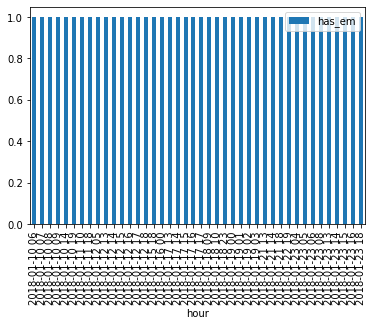

In [56]:
aux2.plot(kind='bar', x='hour', y='has_em')

### Desde hace cuanto hay datos en la 3er antena

In [4]:
FEMALES = [11, 17, 20, 24, 26, 28, 30, 33, 34]
MALES = [10, 14, 21, 22, 23, 25, 27, 29, 31, 32]

In [5]:
nombre_antenas = ["RC1", "RC2", "D1", "D2"] 

In [6]:
birds_recep = birds_recep.filter(lambda x: x['tag_id'] in FEMALES+MALES)

In [7]:
DATA_SUBSET = True
START_TIME = '08:00:00'
END_TIME = '19:00:00'
start_date = '2018-01-10'
end_date = '2018-01-26'

if DATA_SUBSET:
    birds_recep = birds_recep.filter(lambda x: x['timestamp'] >= start_date and  x['timestamp'] < end_date).filter(lambda x: START_TIME <= x['timestamp'].split(' ')[1] < END_TIME)

### Cantidad de recepciones por antena

#### (2) ¿Todas las antenas tienen el mismo impacto? ¿O hay antenas con más emisiones/más puntos alcanzables?

In [8]:
cants_recep_por_antena = []
for i in range(4):
    cant = birds_recep.filter(lambda x: x['recep_{}'.format(i)] > 0).count()
    cants_recep_por_antena.append({'antenna': i, 'cant_recep': cant})

data = pd.DataFrame(cants_recep_por_antena)

In [9]:
data

,antenna,cant_recep
0,0,144142
1,1,158994
2,2,57062
3,3,29993


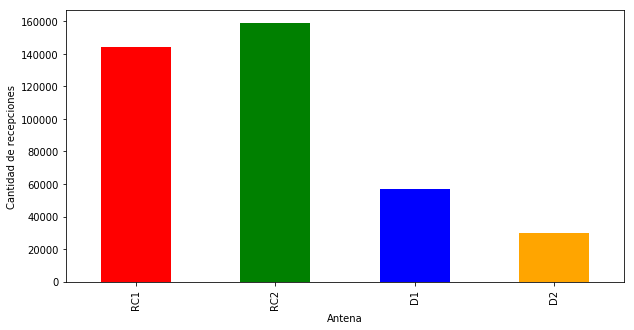

In [16]:
fig, ax = plt.subplots(figsize=(10,5))

data.plot.bar(x='antenna', y='cant_recep', legend=False, color=['red','green','blue','orange'], ax=ax)
ax.set_ylabel('Cantidad de recepciones')
ax.set_xlabel('Antena')
ax.set_xticklabels(nombre_antenas)

fig.savefig('CantidadRecepcionesPajarosPorAntenaHorarioDiurno.png')


### Cantidad de emisions que usan _x_ cantidad de antenas

#### (9) ¿Cuantos emisiones usan 1 antena? ¿Y 2 antenas?

In [10]:
cant_recep = birds_recep.groupBy(lambda x: sum([x['recep_{}'.format(i)] > 0 for i in range(4)])).map(lambda x: {'antennas': x[0],'cant_recep': len(x[1])})
data = pd.DataFrame(cant_recep.collect())

In [11]:
data

,antennas,cant_recep
0,1,296303
1,2,38436
2,3,5204
3,4,351


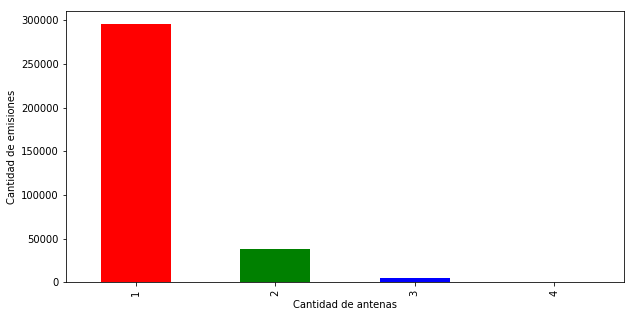

In [20]:
fig, ax = plt.subplots(figsize=(10,5))

data.plot.bar(x='antennas', y='cant_recep', legend=False, color=['red','green','blue','orange'], ax=ax)
ax.set_ylabel('Cantidad de emisiones')
ax.set_xlabel('Cantidad de antenas')

fig.savefig('CantidadAntenasPorEmisionDePajarosHorarioDiurno.png')